In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
# SQLite3 버전 문제 해결: Chroma는 SQLite3 3.35.0 이상이 필요하지만 시스템에는 낮은 버전이 설치되어 있음
# pysqlite3-binary를 사용하여 더 높은 버전의 SQLite3을 제공
import sys
import pysqlite3

# 기존 sqlite3 모듈을 pysqlite3으로 대체
sys.modules['sqlite3'] = pysqlite3
print(f"Using SQLite version: {pysqlite3.sqlite_version}")

Using SQLite version: 3.46.1


In [5]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
import chromadb

client = chromadb.PersistentClient('./real_estate_tax_collection')

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    client=client,
    embedding_function=embedding_function,
    collection_name='real_estate_tax'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [68]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query : str # 사용자 질문
    answer : str # 세율
    tax_base_equation : str # 과세표준 계산 수식
    tax_deduction : str # 공제액
    market_ratio : str # 공정시장가액비율
    tax_base : str # 과세표준 계산

graph_builder = StateGraph(AgentState)

In [7]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [17]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate

llm = ChatOpenAI(model="gpt-4o")
small_llm = ChatOpenAI(model="gpt-4o-mini")

rag_prompt = hub.pull("rlm/rag-prompt")

In [78]:
# 동적으로 context는 retriever로부터 가져오고 질문은 RunnablePassthrough()를 사용해 동적으로 질문을 받는다.
tax_base_retrieval_chain = {'context' : retriever, 'question' : RunnablePassthrough()} | rag_prompt | llm | StrOutputParser()

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연 설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information' : RunnablePassthrough()} | tax_base_equation_prompt | llm | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState) :
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation' : tax_base_equation}

In [79]:
get_tax_base_equation({})

# {'tax_base_equation': '과세표준 = 공시가격 × 공정시장가액 비율 - 기본공제액'}

{'tax_base_equation': '과세표준 = (주택의 공시가격 합계 - 공제금액) × 공정시장가액비율'}

In [23]:
tax_deduction_chain = (
    {'context' : retriever, 'question' : RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState) :
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction' : tax_deduction}

In [24]:
get_tax_deduction({})

{'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자에게 12억 원, 법인 또는 단체에는 6억 원, 그 외의 경우에는 9억 원입니다. 만 60세 이상의 경우, 연령에 따라 최대 40%까지 추가 공제를 받을 수 있습니다.'}

In [42]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=2,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', '아래 정보를 기반으로 공정시장 가액 비율을 계산해주세요\n\nContext:\n{context}'),
    ('human', '{query}')
])

def tax_market_ratio(state: AgentState) :
    query = '2024년 주택 공시가격 공정시장가액비율은 몇%인가요?'
    context = tavily_search_tool.invoke(query)
    tax_market_ratio_chain = tax_market_ratio_prompt | llm | StrOutputParser()
    result = tax_market_ratio_chain.invoke({'context' : context, 'query' : query})

    return {'market_ratio' : result}


In [43]:
tax_market_ratio({})

{'market_ratio': '2024년 주택 공시가격 공정시장가액비율은 60%입니다. 단, 1주택자의 경우 특별히 공정시장가액비율이 조정되어, 재산세 과표가 3억 원 이하이면 43%, 3억 원 초과 6억 원 이하이면 44%, 6억 원 초과이면 45%가 적용됩니다.'}

In [50]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = PromptTemplate.from_template("""
줘진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식 : {tax_base_equation}
공제금액 : {tax_deduction}
공정시장가액비율 : {market_ratio}
사용자 주택 공시가격 정보 : {query}
""")

def calculate_tax_base(state: AgentState) :
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    tax_base_calculation_chain = tax_base_calculation_prompt | llm | StrOutputParser()

    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation' : tax_base_equation,
        'tax_deduction' : tax_deduction,
        'market_ratio' : market_ratio,
        'query' : query
    })

    return {'tax_base' : tax_base}

In [60]:
initial_state = {
    'query' : query,
    'tax_base_equation': '과세표준 = 공시가격 × 공정시장가액 비율 - 기본공제액',
    'tax_deduction': """주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자에게 12억 원, 법인 또는 단체에는 6억 원, 그 외의 경우에는 9억 원입니다. 만 60세 이상의 경우, 연령에 따라 최대 40%까지 추가 공제를 받을 수 있습니다.""",
    'market_ratio' : '2024년 주택 공시가격 공정시장가액비율은 60%입니다.',
    'tax_base' : '''주어진 정보를 바탕으로 과세표준을 계산해보겠습니다. 사용자는 총 3채의 집을 보유하고 있습니다:

    1. **5억 원짜리 집**
    2. **10억 원짜리 집**
    3. **20억 원짜리 집**

    총 공시가격: 5억 + 10억 + 20억 = 35억 원

    과세표준 계산 공식:
    과세표준 = 공시가격 × 공정시장가액 비율 - 기본공제액

    2024년 주택 공시가격 공정시장가액비율은 60%입니다.

    따라서 과세표준은 다음과 같이 계산됩니다:
    - 총 공시가격의 60% = 35억 × 0.6 = 21억 원

    이제 기본공제액을 적용해야 합니다. 공제금액은 조건에 따라 다릅니다. 만약 사용자가 1세대 1주택자에 해당하지 않다면, 9억 원의 공제를 받을 수 있습니다(다주택자일 가능성이 높음).

    그러므로:
    - 과세표준 = 21억 원 - 9억 원 = 12억 원

    이 결과는 연령에 따른 추가 공제는 적용되지 않은 수치이며, 해당 정보가 주어지지 않았습니다. 만약 연령에 따른 추가 공제 정보를 제공한다면, 과세표준은 더욱 낮아질 수 있습니다.

    결론적으로, 기본적인 조건 하에 사용자의 과세표준은 12억 원이 됩니다. 추가 정보가 주어지면 그에 따라 조정될 수 있습니다.'''
}

In [52]:
calculate_tax_base(initial_state)

{'tax_base': '주어진 정보를 바탕으로 과세표준을 계산해보겠습니다. 사용자는 총 3채의 집을 보유하고 있습니다: \n\n1. **5억 원짜리 집**\n2. **10억 원짜리 집**\n3. **20억 원짜리 집**\n\n총 공시가격: 5억 + 10억 + 20억 = 35억 원\n\n과세표준 계산 공식: \n과세표준 = 공시가격 × 공정시장가액 비율 - 기본공제액\n\n2024년 주택 공시가격 공정시장가액비율은 60%입니다. \n\n따라서 과세표준은 다음과 같이 계산됩니다:\n- 총 공시가격의 60% = 35억 × 0.6 = 21억 원\n\n이제 기본공제액을 적용해야 합니다. 공제금액은 조건에 따라 다릅니다. 만약 사용자가 1세대 1주택자에 해당하지 않다면, 9억 원의 공제를 받을 수 있습니다(다주택자일 가능성이 높음).\n\n그러므로:\n- 과세표준 = 21억 원 - 9억 원 = 12억 원\n\n이 결과는 연령에 따른 추가 공제는 적용되지 않은 수치이며, 해당 정보가 주어지지 않았습니다. 만약 연령에 따른 추가 공제 정보를 제공한다면, 과세표준은 더욱 낮아질 수 있습니다. \n\n결론적으로, 기본적인 조건 하에 사용자의 과세표준은 12억 원이 됩니다. 추가 정보가 주어지면 그에 따라 조정될 수 있습니다.'}

In [57]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가 입니다. 아래 문서를 참조해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

    종합부동산세 세율:{context}
    '''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합 부동산세를 계산해주세요

    과세표준 : {tax_base}
    주택 수 : {query}'''),
])

def calculate_tax_rate(state:AgentState) :
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt | llm | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke(
        {
            'context' : context,
            'query' : query,
            'tax_base' : tax_base
        }
    )
    print(f'tax_rate == {tax_rate}')
    return {'answer' : tax_rate}


In [59]:
calculate_tax_rate(initial_state)

tax_rate == 사용자는 총 3채의 집을 보유하고 있으므로, 3주택 이상 소유한 경우의 세율이 적용됩니다. 주어진 과세표준은 12억 원입니다. 3주택 이상 소유한 경우의 세율표에 따르면, 과세표준이 12억 원일 경우 세율은 다음과 같습니다:

과세표준이 6억 원 초과 12억 원 이하인 경우:
- 기본 세액: 360만 원
- 6억 원을 초과하는 금액의 1000분의 10

따라서, 과세표준 12억 원에 대한 계산은 다음과 같습니다:

1. 12억 원에서 6억 원을 초과하는 금액: 12억 원 - 6억 원 = 6억 원
2. 초과금액에 대한 세금: 6억 원 × 0.0010 = 600만 원
3. 총 세액: 360만 원 + 600만 원 = 960만 원

따라서 사용자가 내야 하는 종합부동산세는 960만 원입니다.


{'answer': '사용자는 총 3채의 집을 보유하고 있으므로, 3주택 이상 소유한 경우의 세율이 적용됩니다. 주어진 과세표준은 12억 원입니다. 3주택 이상 소유한 경우의 세율표에 따르면, 과세표준이 12억 원일 경우 세율은 다음과 같습니다:\n\n과세표준이 6억 원 초과 12억 원 이하인 경우:\n- 기본 세액: 360만 원\n- 6억 원을 초과하는 금액의 1000분의 10\n\n따라서, 과세표준 12억 원에 대한 계산은 다음과 같습니다:\n\n1. 12억 원에서 6억 원을 초과하는 금액: 12억 원 - 6억 원 = 6억 원\n2. 초과금액에 대한 세금: 6억 원 × 0.0010 = 600만 원\n3. 총 세액: 360만 원 + 600만 원 = 960만 원\n\n따라서 사용자가 내야 하는 종합부동산세는 960만 원입니다.'}

In [72]:
graph_builder.nodes.clear()
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('tax_market_ratio', tax_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [73]:
from langgraph.graph import START, END

graph_builder.edges.clear()

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'tax_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('tax_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)


In [74]:
graph = graph_builder.compile()

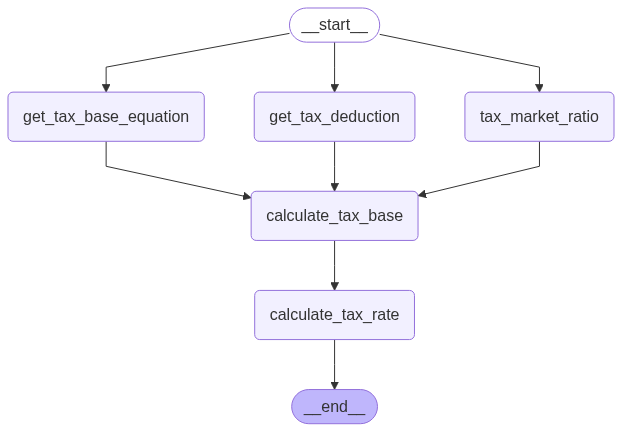

In [76]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [77]:
inital_state = {'query' : query}
graph.invoke(inital_state)

tax_rate == 사용자가 소지한 주택의 과세표준과 주택 수에 따른 종합부동산세를 계산해봅시다. 사용자는 총 3채의 주택을 보유하고 있으며, 총 과세표준은 3억 원입니다. 3주택 이상 보유한 경우의 세율을 적용해야 합니다.

| 과세표준              | 세율                                  |
|---------------------|-------------------------------------|
| 3억 원 이하           | 1천분의 5                              |

따라서, 종합부동산세는 다음과 같이 계산됩니다.

- 과세표준: 3억 원
- 세율: 1천분의 5

계산식은 다음과 같습니다:

\[ \text{세금} = \text{과세표준} \times \left(\frac{\text{세율}}{1000}\right) \]

따라서,

\[ \text{세금} = 3억 원 \times \left(\frac{5}{1000}\right) \]

\[ \text{세금} = 1,500,000 \text{ 원} \]

사용자는 총 150만 원의 종합부동산세를 납부해야 합니다.


{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '사용자가 소지한 주택의 과세표준과 주택 수에 따른 종합부동산세를 계산해봅시다. 사용자는 총 3채의 주택을 보유하고 있으며, 총 과세표준은 3억 원입니다. 3주택 이상 보유한 경우의 세율을 적용해야 합니다.\n\n| 과세표준              | 세율                                  |\n|---------------------|-------------------------------------|\n| 3억 원 이하           | 1천분의 5                              |\n\n따라서, 종합부동산세는 다음과 같이 계산됩니다.\n\n- 과세표준: 3억 원\n- 세율: 1천분의 5\n\n계산식은 다음과 같습니다:\n\n\\[ \\text{세금} = \\text{과세표준} \\times \\left(\\frac{\\text{세율}}{1000}\\right) \\]\n\n따라서,\n\n\\[ \\text{세금} = 3억 원 \\times \\left(\\frac{5}{1000}\\right) \\]\n\n\\[ \\text{세금} = 1,500,000 \\text{ 원} \\]\n\n사용자는 총 150만 원의 종합부동산세를 납부해야 합니다.',
 'tax_base_equation': '과세표준 = (공시가격 × 공정시장가액비율) - 기본공제',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원, 법인 또는 법인으로 보는 단체는 6억 원, 그 외의 경우에는 9억 원입니다.',
 'market_ratio': '2024년 주택 공시가격의 공정시장가액비율은 60%입니다.',
 'tax_base': '사용자의 경우, 5억 원, 10억 원, 20억 원짜리 주택을 각각 한 채씩 소유하고 있습니다. 이를 바탕으로 